# Variational Quantum Classifier on IBM Qiskit

Quantum Machine Learning (QML) techniques are widely used and researched today. They are motivated by advances achieved in different knowledge fields and their resulting commercial applications.  However, the noise and decoherence in real quantum devices limit their implementation by inducing errors in the calculations.  

We will implement a Variational Quantum Classifier (VQC) presented in Figure 1, a hybrid approach with two quantum components: a feature map encoding classical data into quantum states, and a variational unitary circuit $U(\theta)$ with a given number of layers of parameters $\theta$. These parameters are optimized and updated during training by minimizing a cost function on a classical device. We will cover:

* Implementing a VQC on a toy dataset, training it using IBM Qiskit Simulator,
* Testing the model using IBM Qiskit Simulator,
* Testing the model using real quantum devices,

<div style="text-align: center;">
    <img src="img/vqc.png" alt="VQC circuit scheme">
    <p><strong>Figure 1:</strong> Variational Quantum Classifier circuit scheme.</p>
</div>


## Imports and initialization
To install the required packages, use the following command:

In [ ]:
# !pip install numpy matplotlib qiskit qiskit-machine-learning qiskit-ibm-runtime scikit-learn 

In [2]:
# Packages for synthetic data generation and pre-processing.  
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

# Qiskit packages
from qiskit.circuit.library import ZZFeatureMap,RealAmplitudes
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.optimizers import SPSA
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Packages for data visualization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

We start by creating synthetic data using Scikit-learn ```make_blobs```, with this method we generate 100 samples out of two isotropic Gaussian blobs for binary classification    

In [ ]:
# X, y = make_moons(n_samples=100, noise=0.1, random_state=42)
X, y = make_blobs(n_samples=100, centers=2, n_features=4, cluster_std=0.1, random_state=42)

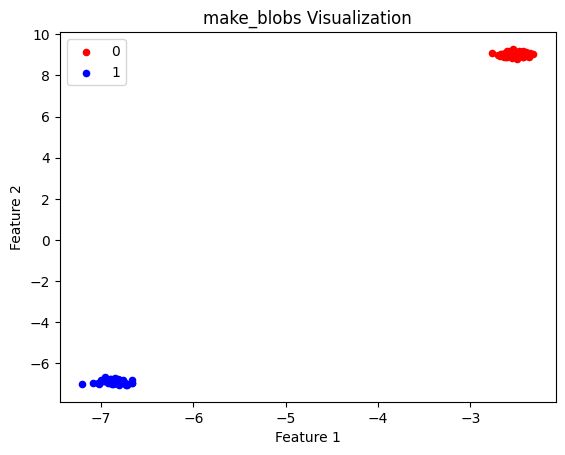

In [4]:
# Create a Pandas DataFrame for easier plotting
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))

colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

plt.title('make_blobs Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Then, we randomly divide the data into two subsets, one for training and one for testing. The testing subset will contain 20% of the generated records and will not be part of the training process. 

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=24)

## Circuit Preparation

One of the key components of the VQC method is the feature map definition, which maps data nonlinearly into a vector of the Hilbert space of density matrices $|\phi(\tilde{x})\rangle\langle\phi(\tilde{x})|$. The correct data mapping could lead to better classification performance. For our data, we will use a second-order diagonal expansion ```ZZFeatureMap```, where the number of qubits $n$ in the quantum circuit is equal to the number of features from the classical data, encoded  using coefficients $\phi_S(\mathbf{x})$, where $S \subseteq\{1, \ldots, n \}$, $|S|\leq 2$ and:

$$
\phi_S:x \mapsto \Bigg\{
\begin{array}{ll}
    x_i & \text{if } S=\{i\} \\
    (\pi-x_i)(\pi-x_j) & \text{if } S=\{i,j\}
\end{array}
$$

The variational circuit selected is ```RealAmplitudes``` that alternates layers of parametric $RY$ gates with $CNOT$, we will use 4 repetitions leading to 20 tunable parameters.

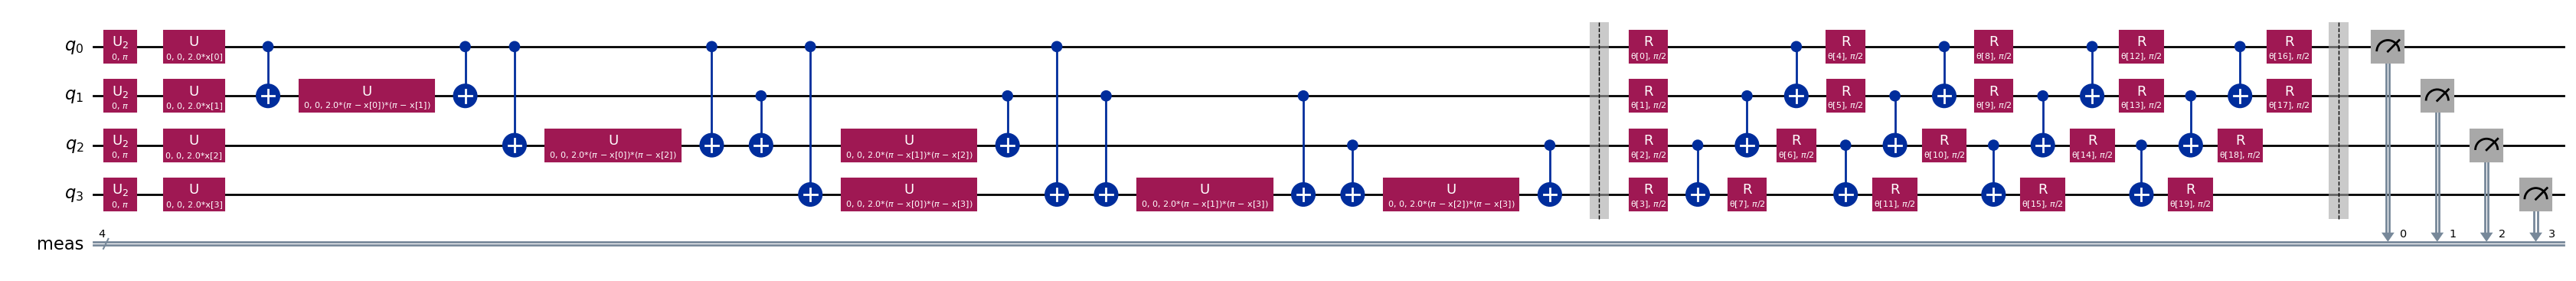

In [6]:
feature_map = ZZFeatureMap(feature_dimension=4, reps=1)
feature_map.barrier()
var_form = RealAmplitudes(num_qubits=4, reps=4)
circuit = feature_map.compose(var_form).decompose()
circuit.measure_all()
circuit.decompose().draw(output="mpl", fold=-1, style="iqp")


## VQC Training
Next, we will create the functions needed to tune the variational parameters from our quantum circuit. First, we will assign the data to the parameters of the feature map, then we will update $\tilde{\theta}$ in the variational circuit with the optimization algorithm.

In [7]:
def circuit_instance(data, variational):
    """
    Assigns parameter values to the quantum circuit.
    """
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return circuit.assign_parameters(parameters)


We need to translate the predictions obtained with the quantum circuit into probabilities. To achieve this, we evaluate the parity from the bitstrings and calculate their probability of occurrence given the number of shots from the execution. 

In [8]:
def labels_probability(results):
    """
    Converts a dictionary of bitstrings and their counts, to parities and their counts
    """
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = (sum(int(k) for k in list(bitstring))+1) % 2
        probabilities[label] += counts / shots
    return probabilities

Then, we create the function ```classification_probability_simulation``` to build a quantum circuit for each data point using the variational parameters, this function runs these circuits using the IBM Qiskit Simulator and calculates the classification probabilities based on the measurement results. We use the ```cross_entropy_loss``` function to provide a measure of prediction accuracy.

In [ ]:
def classification_probability_simulation(data, variational):
    """
    Classify data points using given parameters.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    sampler = StatevectorSampler() # Estimator() matrix_state_product
    results = sampler.run(circuits).result()
    # print(results[1].data.meas.get_counts())
    classification = [labels_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    return classification

In [10]:
def cross_entropy_loss(classification, expected):
    """
    Calculate accuracy of predictions using cross entropy loss.
    """
    p = classification.get(expected)  
    return -np.log(p + 1e-10)

Finally, with the``` cost_function``` we evaluate the overall performance of the quantum circuit given variational parameters on the dataset by finding the average of the cross-entropy loss across all data points, which is then used by the ```objective_function``` to minimize the cost.

In [11]:
def cost_function(data, labels, variational):
    """
    Evaluates performance of our circuit with variational parameters on data.
    """
    classifications = classification_probability_simulation(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost


In [12]:
def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(train_data, train_labels, variational)


Now we are ready to run the program and obtain the variational parameters from the circuit, using the SPSA algorithm from SciPy to minimize the function.

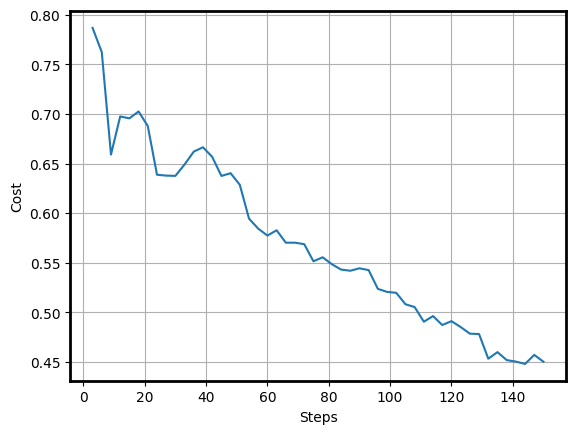

In [13]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
             
# Set up the optimization
log = OptimizerLog()
optimizer = SPSA(maxiter=50, callback=log.update)

initial_point = np.zeros((var_form.num_parameters))

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.grid(True)
plt.rc('axes', linewidth=2)  # Set the axes linewidth globally
ax = plt.gca()  # Get current axes
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.show()

## Model Test

Now that the model is trained, we will evaluate its performance using the test subset we isolated at the beginning. We will conduct three experiments: 
*	**Simulator Test:** We will test the model using the simulator, which will provide information about the model in a noiseless environment and serve as the baseline to evaluate the performance of the executions using real devices.
*	**Qiskit Test:** We will test the model executing the inference circuits on a real device to assess the noise and decoherence effect in the model.


In [14]:
def create_conf_mat(y_true, y_pred, title):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create a custom colormap
    colors = [(1, 1, 1), (0/255, 255/255, 0/255)] 
    n_bins = 100  # Number of bins in the colormap
    cmap_name = 'custom_blue'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    # Display confusion matrix
    fig, ax = plt.subplots()
    cax = ax.matshow(cm_normalized, cmap=custom_cmap)

    # Add color bar
    fig.colorbar(cax)

    # Set predefined RGB color for the text
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            color = 'white' if i == j else 'black'
            ax.text(j, i, f'{cm_normalized[i, j]:.1f}%', va='center', ha='center', color=color)

    # Set predefined background color for the diagonal elements (e.g., RGB (255, 255, 0))
    diagonal_color = (98/255, 35/255, 223/255)  # Normalize to 0-1 range
    for i in range(cm_normalized.shape[0]):
        ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, fill=True, color=diagonal_color, alpha=0.3))

    # Set predefined background color for the plot (e.g., RGB (240, 240, 240))
    background_color = (1, 1, 1)  # Normalize to 0-1 range
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

### Simulator Test

Simulated Test Accuracy: 90.00%


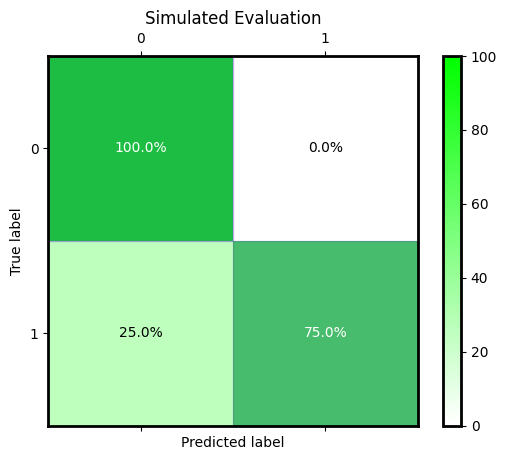

In [15]:
def test_classifier(data, labels, variational):
    """
    Gets classifier'spredictions and calculates accuracy 
    """
    probability = classification_probability_simulation(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    print(f"Simulated Test Accuracy: {accuracy * 100:.2f}%")
    create_conf_mat(labels, predictions, "Simulated Evaluation")
    return accuracy, predictions

accuracy_sim, predictions_sim = test_classifier(test_data, test_labels, opt_var)


### Using real devices

For running on a real device we need to provide the account information, in this example we are using [IBM Quantum](https://quantum.ibm.com/) hardware, then we need to define the hub, group, project and token. When using Fire Opal you also need to provide your [credentials](https://accounts.q-ctrl.com/), and it will execute the circuits on your behalf.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='*****'
)

Next, we will search for the least busy device to execute our circuits

In [19]:
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
backend


<IBMBackend('ibm_brisbane')>

### Qiskit Test

When using real devices, we must modify some functions to execute the circuits and collect the information. We need to change the Sampler function to define the hardware backend we will use, and we need to rewrite the circuit to match the topology from this backend in a process known as [transpilation](https://docs.quantum.ibm.com/api/qiskit/transpiler). 

In [20]:
sampler = Sampler(backend)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

In [21]:
def classification_probability_qiskit(data, variational):
    """
    Classify data points using given parameters.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    isa_circuit = pm.run(circuits)
    results = sampler.run(isa_circuit, shots=1024).result()
    classification = [
        labels_probability(i['__value__']['data'].meas.get_counts()) for i in results]
    return classification

Qiskit Test Accuracy: 60.00%


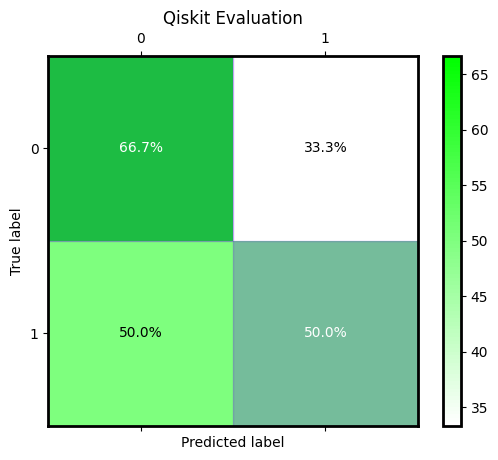

In [22]:
def test_classifier(data, labels, variational):
    """
    Gets classifier'spredictions and calculates accuracy 
    """
    probability = classification_probability_qiskit(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    print(f"Qiskit Test Accuracy: {accuracy * 100:.2f}%")
    create_conf_mat(labels, predictions, "Qiskit Evaluation")
    return accuracy, predictions

accuracy_qiskit, predictions_qiskit = test_classifier(test_data, test_labels, opt_var)